# Get data

In [1]:
import os
import tarfile
import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    os.makedirs(housing_path, exist_ok=True)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [2]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [3]:
housing = load_housing_data(HOUSING_PATH)
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
# get info about the dataset
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [5]:
# info on a specific column
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [6]:
# summary of numerical attributes
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


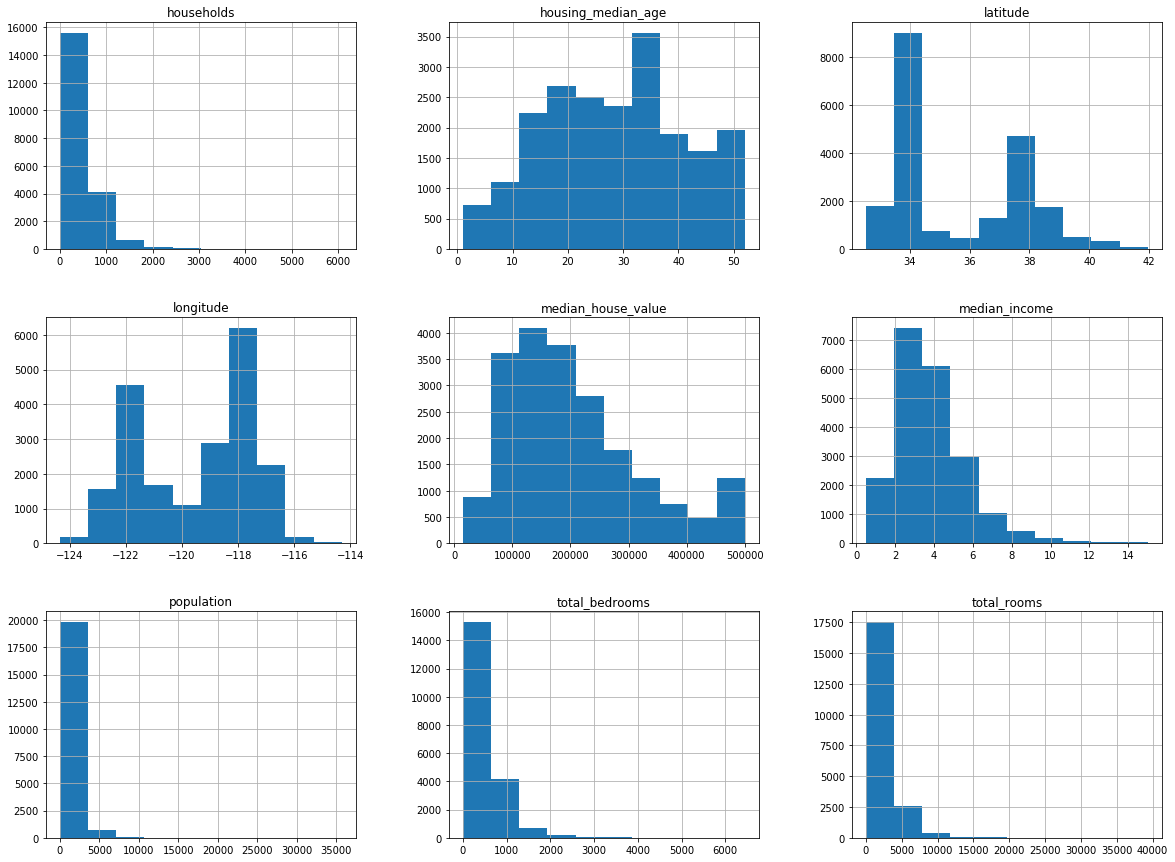

In [7]:
# plot histogram

# only in a jupyter notebook
%matplotlib inline

import matplotlib.pyplot as plt

housing.hist(bins=10, figsize=(20,15))
plt.show()

# Importance of test set generation
##### (the test set must have zero bias)

In [8]:
# create a test set
# its good to make one now to prevent data snooping bias
# this prevents you to be bias when choosing an ml model

import numpy as np

def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [9]:
# avoid the ML algo to see the whole data set
# one solution is to save the test set on the first run and use it on future runs
# another solution is set the number generator's seed before calling np.random.permutation()
# solution only breaks when you fetch an updated dataset

train_set, test_set = split_train_test(housing, 0.2)
print("number of train_set:", len(train_set))
print("number of test_set:", len(test_set))

number of train_set: 16512
number of test_set: 4128


In [10]:
# use each instance's identifier and put that instance in the test set
# to ensure a stable train/test split even after updating the dataset
# one implementation of the solution

from zlib import crc32

def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [11]:
# set identifier ID column
housing_with_id = housing.reset_index() # adds an 'index' column
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

In [12]:
# set stable feature as a unique identifier
# so that new data can be appended
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")

In [13]:
# sklearn has its own train test split function that has additional features

from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

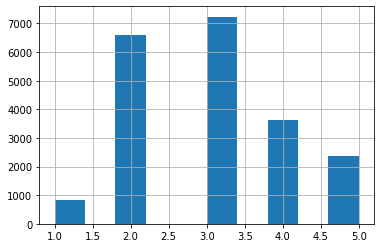

In [14]:
# create a 5 categories for the income brackets
housing["income_cat"] = pd.cut(housing["median_income"],
                              bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                              labels=[1, 2, 3, 4, 5])
housing["income_cat"].hist()

In [15]:
# stratified sampling
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

strat_test_set["income_cat"].value_counts()/len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64

In [16]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

# Visualizing data

In [17]:
# create a copy of the test set to avoid harming the full dataset
housing = strat_train_set.copy()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,286600.0,<1H OCEAN
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,340600.0,<1H OCEAN
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,196900.0,NEAR OCEAN
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,46300.0,INLAND
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,254500.0,<1H OCEAN


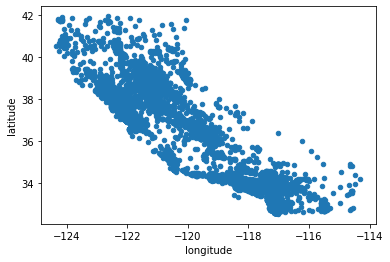

In [18]:
# visualize data based on long and lat
housing.plot(kind="scatter", x="longitude", y="latitude")

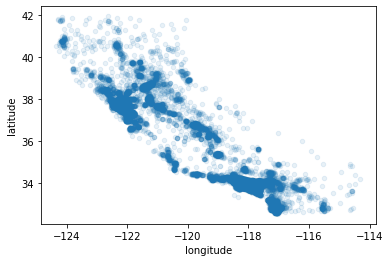

In [19]:
# set alpha to see the desnity of the data points
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)

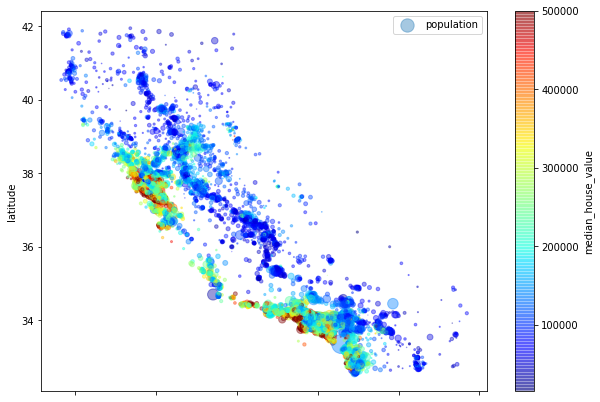

In [20]:
# color map based on housing prices
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
             s=housing["population"]/100, label="population", figsize=(10,7),
             c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,)
plt.legend()

In [21]:
# for small datasets we can calculate the standard correlation coefficients (Pearson's r)
corr_matrix = housing.corr()

In [22]:
# see how each attribute correlates with the medial house value
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000022CA86581C8>,
      dtype=object)

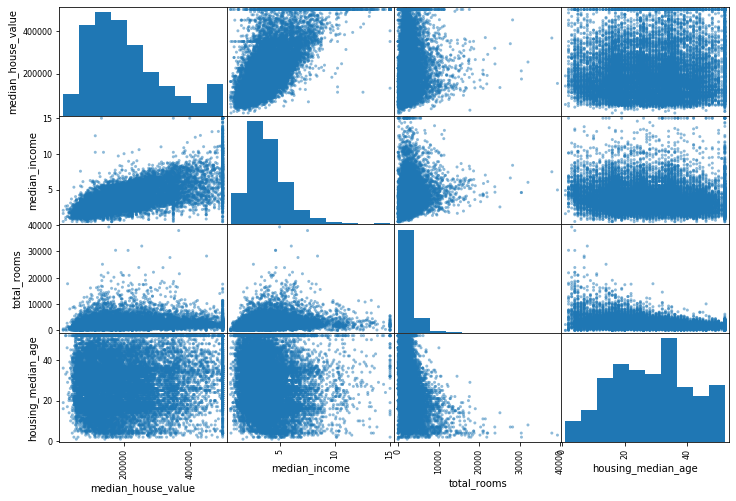

In [23]:
# to check correlation at different attributes use a scatter matrix
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12,8))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000022CA8D3B6C8>,
      dtype=object)

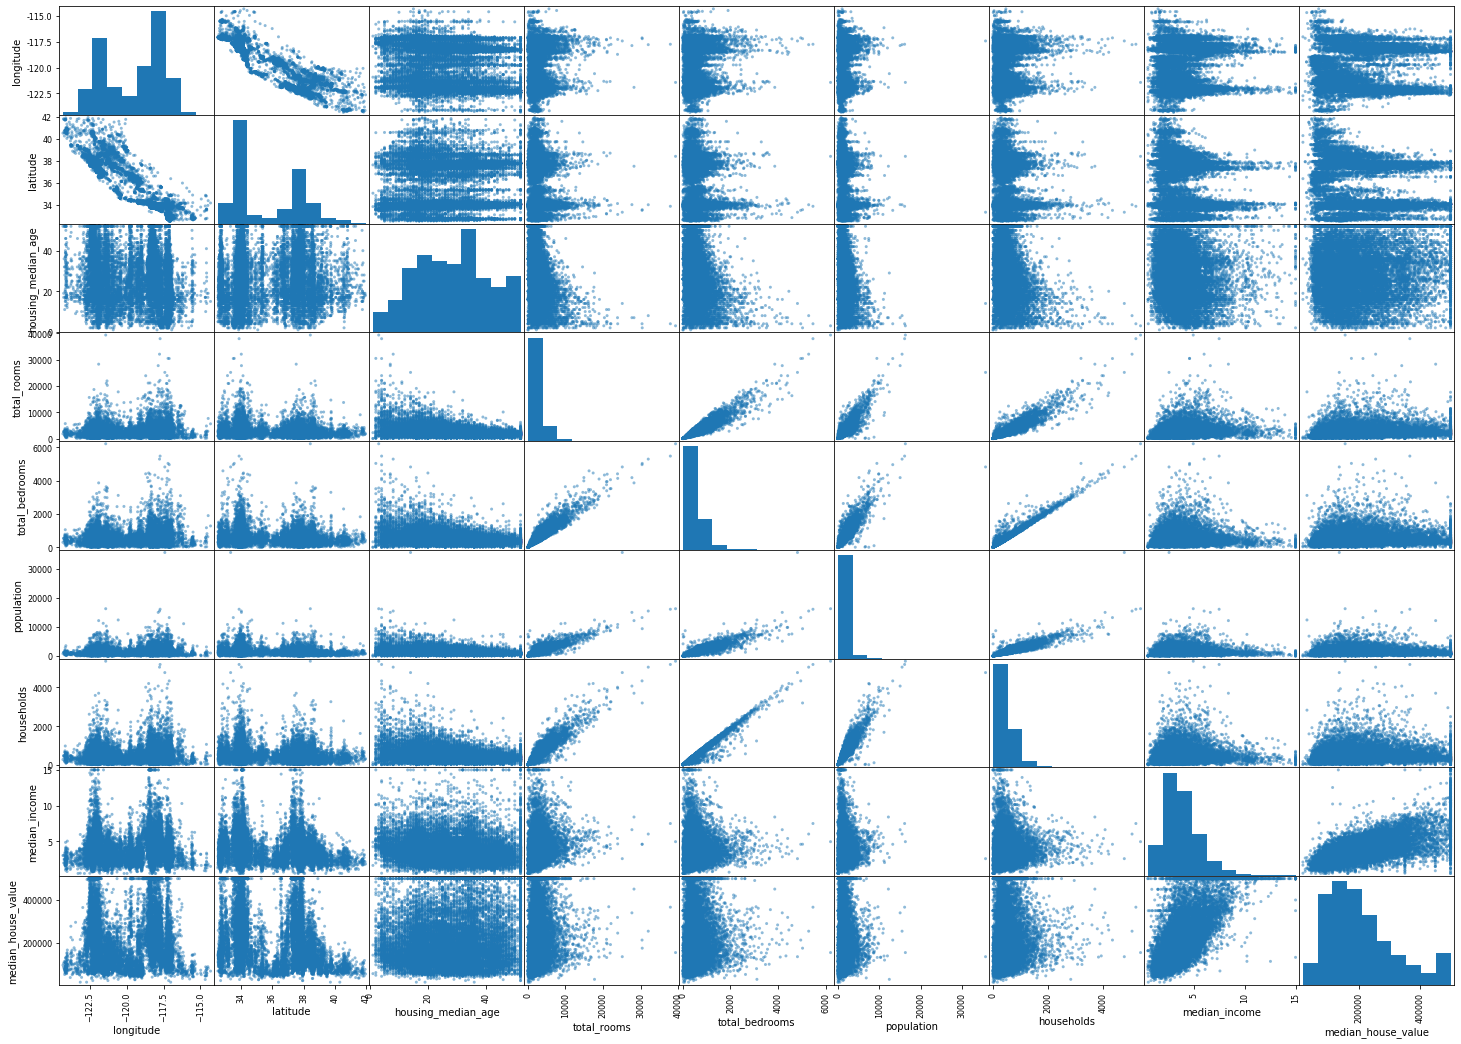

In [24]:
# for all attributes correlation
scatter_matrix(housing, figsize=(25,18))

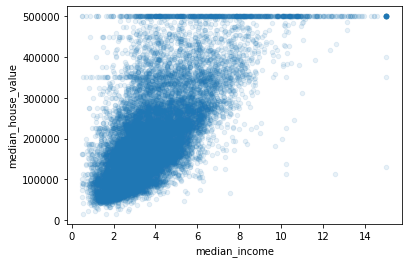

In [25]:
# looking at a specific relationship
housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000022CA8FE1DC8>,
      dtype=object)

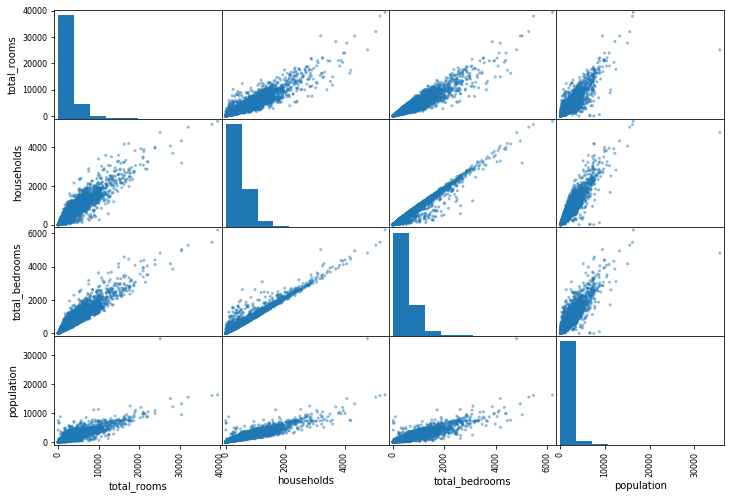

In [26]:
# relationship of total rooms and households
attributes = ["total_rooms", "households", "total_bedrooms", "population"]
scatter_matrix(housing[attributes], figsize=(12,8))

In [27]:
# numerical representation of the attributes
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"] # creates a new attribute in the dataset
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"] = housing["population"]/housing["households"]

corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

In [28]:
# new attributes are added to the dataset
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,rooms_per_household,bedrooms_per_room,population_per_household
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,286600.0,<1H OCEAN,4.625369,0.223852,2.094395
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,340600.0,<1H OCEAN,6.008850,0.159057,2.707965
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,196900.0,NEAR OCEAN,4.225108,0.241291,2.025974
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,46300.0,INLAND,5.232295,0.200866,4.135977
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,254500.0,<1H OCEAN,4.505810,0.231341,3.047847


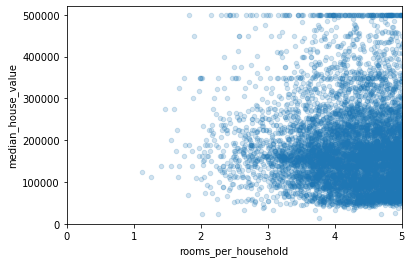

In [29]:
housing.plot(kind="scatter", x="rooms_per_household", y="median_house_value", alpha=0.2)
plt.axis([0, 5, 0, 520000])
plt.show()

In [30]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_household,bedrooms_per_room,population_per_household
count,16512.000000,16512.000000,16512.000000,16512.000000,16354.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16354.000000,16512.000000
mean,-119.575834,35.639577,28.653101,2622.728319,534.973890,1419.790819,497.060380,3.875589,206990.920724,5.440341,0.212878,3.096437
std,2.001860,2.138058,12.574726,2138.458419,412.699041,1115.686241,375.720845,1.904950,115703.014830,2.611712,0.057379,11.584826
min,-124.350000,32.540000,1.000000,6.000000,2.000000,3.000000,2.000000,0.499900,14999.000000,1.130435,0.100000,0.692308
25%,-121.800000,33.940000,18.000000,1443.000000,295.000000,784.000000,279.000000,2.566775,119800.000000,4.442040,0.175304,2.431287
50%,-118.510000,34.260000,29.000000,2119.500000,433.000000,1164.000000,408.000000,3.540900,179500.000000,5.232284,0.203031,2.817653
75%,-118.010000,37.720000,37.000000,3141.000000,644.000000,1719.250000,602.000000,4.744475,263900.000000,6.056361,0.239831,3.281420
max,-114.310000,41.950000,52.000000,39320.000000,6210.000000,35682.000000,5358.000000,15.000100,500001.000000,141.909091,1.000000,1243.333333


# Prepare data for ML

In [31]:
# revert to a clean training set
housing = strat_train_set.drop("median_house_value", axis=1) # drops labels for training set
housing_labels = strat_train_set["median_house_value"].copy()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,<1H OCEAN
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,<1H OCEAN
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,NEAR OCEAN
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,INLAND
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,<1H OCEAN


In [32]:
# find samples that have incomplte data
sample_incomplete_rows = housing[housing.isnull().any(axis=1)].head()
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
4629,-118.30,34.07,18.0,3759.0,NaN,3296.0,1462.0,2.2708,<1H OCEAN
6068,-117.86,34.01,16.0,4632.0,NaN,3038.0,727.0,5.1762,<1H OCEAN
17923,-121.97,37.35,30.0,1955.0,NaN,999.0,386.0,4.6328,<1H OCEAN
13656,-117.30,34.05,6.0,2155.0,NaN,1039.0,391.0,1.6675,INLAND
19252,-122.79,38.48,7.0,6837.0,NaN,3468.0,1405.0,3.1662,<1H OCEAN


In [33]:
# few ways to fix this
# option 1: remove NaN
sample_incomplete_rows = housing[housing.isnull().any(axis=1)].head()
sample_incomplete_rows = housing.dropna(subset=["total_bedrooms"])
sample_incomplete_rows.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,<1H OCEAN
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,<1H OCEAN
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,NEAR OCEAN
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,INLAND
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,<1H OCEAN


In [34]:
# option 2: remove column
sample_incomplete_rows = housing[housing.isnull().any(axis=1)].head()
sample_incomplete_rows.drop("total_bedrooms", axis=1, inplace=True)
sample_incomplete_rows.head()

,longitude,latitude,housing_median_age,total_rooms,population,households,median_income,ocean_proximity
4629,-118.30,34.07,18.0,3759.0,3296.0,1462.0,2.2708,<1H OCEAN
6068,-117.86,34.01,16.0,4632.0,3038.0,727.0,5.1762,<1H OCEAN
17923,-121.97,37.35,30.0,1955.0,999.0,386.0,4.6328,<1H OCEAN
13656,-117.30,34.05,6.0,2155.0,1039.0,391.0,1.6675,INLAND
19252,-122.79,38.48,7.0,6837.0,3468.0,1405.0,3.1662,<1H OCEAN


In [35]:
# option 3: set values to some value (zero, mean, median, etc.)
sample_incomplete_rows = housing[housing.isnull().any(axis=1)].head()
median = housing["total_bedrooms"].median()
sample_incomplete_rows["total_bedrooms"].fillna(median, inplace=True)
sample_incomplete_rows.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
4629,-118.30,34.07,18.0,3759.0,433.0,3296.0,1462.0,2.2708,<1H OCEAN
6068,-117.86,34.01,16.0,4632.0,433.0,3038.0,727.0,5.1762,<1H OCEAN
17923,-121.97,37.35,30.0,1955.0,433.0,999.0,386.0,4.6328,<1H OCEAN
13656,-117.30,34.05,6.0,2155.0,433.0,1039.0,391.0,1.6675,INLAND
19252,-122.79,38.48,7.0,6837.0,433.0,3468.0,1405.0,3.1662,<1H OCEAN


In [36]:
# sklearn SimpleImputer tool to deal with missing values
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

In [37]:
# median can only be computed on numerical attributes
# create a copy of the data without the text attribute like ocean_proximity

housing_num = housing.drop("ocean_proximity", axis=1)
# alternatively: housing_num = housing.select_dtypes(include=[np.number])

In [38]:
# fit imputer instance to the training data
imputer.fit(housing_num)

# its safer to add imputer to all numerical attributes
# as new data may have missing values

SimpleImputer(add_indicator=False, copy=True, fill_value=None,
              missing_values=nan, strategy='median', verbose=0)

In [39]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [40]:
housing_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [41]:
# apply imputer to transform the training set
X = imputer.transform(housing_num)

In [42]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing.index)

In [43]:
housing_tr.loc[sample_incomplete_rows.index.values]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
4629,-118.30,34.07,18.0,3759.0,433.0,3296.0,1462.0,2.2708
6068,-117.86,34.01,16.0,4632.0,433.0,3038.0,727.0,5.1762
17923,-121.97,37.35,30.0,1955.0,433.0,999.0,386.0,4.6328
13656,-117.30,34.05,6.0,2155.0,433.0,1039.0,391.0,1.6675
19252,-122.79,38.48,7.0,6837.0,433.0,3468.0,1405.0,3.1662


In [44]:
imputer.strategy

'median'

In [45]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing_num.index)
housing_tr.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347


In [46]:
# handling text and categorical attributes
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(10)

,ocean_proximity
17606,<1H OCEAN
18632,<1H OCEAN
14650,NEAR OCEAN
3230,INLAND
3555,<1H OCEAN
19480,INLAND
8879,<1H OCEAN
13685,INLAND
4937,<1H OCEAN
4861,<1H OCEAN


In [47]:
# ML likes to work with numbers
# convert these categorical attributes (categories)
# from text to numbers
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

array([[0.],
       [0.],
       [4.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.]])

In [48]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [49]:
# ML algo will assume that 2 nearby values
# are more similar than 2 distant values
# its fine in some cases
# (i.e. ordered categories like "bad", "average", "good" and "excellent")
# it is not the case fo ocean_proximity column
# a common solution for this issue is one-hot encoding,
# where only one attribute equals to 1 (hot), while the other will be 0 (cold)
# i.e. attribute = 1 when category = "<1H OCEAN" (0 otherwise),
# attribute = to 1 when category = "INLAND" (0 otherwise), and so on
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot
# the output is a SciPy sparse matrix which is useful when you have
# categorical attributes with thousands of categories

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [50]:
# default OneHotEncoder class returns a sparse array,
# but we can convert it to a dense array if needed
# by calling the toarray() method
housing_cat_1hot.toarray()

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [51]:
# alternatively you can set sparse=False when creating the OneHotEncoder
cat_encoder = OneHotEncoder(sparse=False)
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [52]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [53]:
# create a custom transformer to add extra ttributes
from sklearn.base import BaseEstimator, TransformerMixin

# column index
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True): # no *args or **kwargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self # nothing else to do
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                        bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]
        
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

In [54]:
housing_extra_attribs = pd.DataFrame(
    housing_extra_attribs,
    columns=list(housing.columns)+["rooms_per_household", "population_per_houshold"],
    index=housing.index
)
housing_extra_attribs.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,population_per_houshold
17606,-121.89,37.29,38,1568,351,710,339,2.7042,<1H OCEAN,4.62537,2.0944
18632,-121.93,37.05,14,679,108,306,113,6.4214,<1H OCEAN,6.00885,2.70796
14650,-117.2,32.77,31,1952,471,936,462,2.8621,NEAR OCEAN,4.22511,2.02597
3230,-119.61,36.31,25,1847,371,1460,353,1.8839,INLAND,5.23229,4.13598
3555,-118.59,34.23,17,6592,1525,4459,1463,3.0347,<1H OCEAN,4.50581,3.04785


In [55]:
# pipeline for preprocessing numerical attributes
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("attribs_adder", CombinedAttributesAdder()),
    ("std_scaler", StandardScaler()),
])

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [56]:
housing_num_tr

array([[-1.15604281,  0.77194962,  0.74333089, ..., -0.31205452,
        -0.08649871,  0.15531753],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.21768338,
        -0.03353391, -0.83628902],
       [ 1.18684903, -1.34218285,  0.18664186, ..., -0.46531516,
        -0.09240499,  0.4222004 ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.3469342 ,
        -0.03055414, -0.52177644],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.02499488,
         0.06150916, -0.30340741],
       [-1.43579109,  0.99645926,  1.85670895, ..., -0.22852947,
        -0.09586294,  0.10180567]])

In [57]:
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", OneHotEncoder(), cat_attribs),
])

housing_prepared = full_pipeline.fit_transform(housing)

In [58]:
housing_prepared

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

In [59]:
housing_prepared.shape

(16512, 16)

# Select and train a model

In [60]:
# train with linear regression
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
X = housing_prepared
y = housing_labels
lin_reg.fit(X,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [61]:
# let's try out on a few instances from the training set
some_data =housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print("Predictions:", lin_reg.predict(some_data_prepared))
print("Labels:", list(some_labels))
some_data_prepared

Predictions: [210644.60459286 317768.80697211 210956.43331178  59218.98886849
 189747.55849879]
Labels: [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


array([[-1.15604281,  0.77194962,  0.74333089, -0.49323393, -0.44543821,
        -0.63621141, -0.42069842, -0.61493744, -0.31205452, -0.08649871,
         0.15531753,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , -0.90896655, -1.0369278 ,
        -0.99833135, -1.02222705,  1.33645936,  0.21768338, -0.03353391,
        -0.83628902,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, -0.31365989, -0.15334458,
        -0.43363936, -0.0933178 , -0.5320456 , -0.46531516, -0.09240499,
         0.4222004 ,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        ],
       [-0.01706767,  0.31357576, -0.29052016, -0.36276217, -0.39675594,
         0.03604096, -0.38343559, -1.04556555, -0.07966124,  0.08973561,
        -0.19645314,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.49247384, -0.65929936, -0

In [62]:
# measure regression model with RMSE
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
print("prediction error:", lin_rmse)

prediction error: 68628.19819848923


In [63]:
# measure regression model with MSE
from sklearn.metrics import mean_absolute_error

lin_mae = mean_absolute_error(housing_labels, housing_predictions)
print("prediction error:", lin_mae)

prediction error: 49439.89599001897


In [64]:
# decision tree regressor
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
X = housing_prepared
y = housing_labels
tree_reg.fit(X, y)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [65]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
print("prediction error:", tree_rmse)

prediction error: 0.0


# Fine-tune your model

In [66]:
from sklearn.model_selection import cross_val_score

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

In [67]:
scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                        scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores) 
display_scores(tree_rmse_scores)

Scores: [70193.74620356 67202.52211409 70656.92756811 68752.52824937
 71031.40419215 74924.92671365 70289.11676323 72523.09273225
 76144.92518096 70324.84333684]
Mean: 71204.40330542158
Standard deviation: 2549.101770125893


In [68]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [66782.73843989 66960.118071   70347.95244419 74739.57052552
 68031.13388938 71193.84183426 64969.63056405 68281.61137997
 71552.91566558 67665.10082067]
Mean: 69052.46136345083
Standard deviation: 2731.674001798349


In [69]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
X = housing_prepared
y = housing_labels
forest_reg.fit(X, y)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [70]:
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
print("prediction error:", forest_rmse)

prediction error: 18603.515021376355


In [71]:
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                             scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [49519.80364233 47461.9115823  50029.02762854 52325.28068953
 49308.39426421 53446.37892622 48634.8036574  47585.73832311
 53490.10699751 50021.5852922 ]
Mean: 50182.303100336096
Standard deviation: 2097.0810550985693


In [72]:
from sklearn.svm import SVR

svm_reg = SVR(kernel="linear")
svm_reg.fit(housing_prepared, housing_labels)
housing_predictions = svm_reg.predict(housing_prepared)
svm_mse = mean_squared_error(housing_labels, housing_predictions)
svm_rmse = np.sqrt(svm_mse)
svm_rmse

111094.6308539982

In [73]:
# Fine tuning your model
# Grid search - finding the best combination of hyper parameters
from sklearn.model_selection import GridSearchCV

param_grid = [
    # try 12 (3x4) combinations of hyperparameters
    {"n_estimators": [3, 10, 30], "max_features": [2, 4, 6, 8]},
    # then try 6 (2x3) combinations with bootsraps set as False
    {"bootstrap": [False], "n_estimators": [3, 10], "max_features": [2, 3, 4]},
]

forest_reg = RandomForestRegressor(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                          scoring="neg_mean_squared_error",
                          return_train_score=True)

X = housing_prepared
y = housing_labels
grid_search.fit(X,y)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=42,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jobs

In [74]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [75]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=8, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=30, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [76]:
cvres = grid_search.cv_results_
n=0
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    n += 1
    if n <= 12:
        print(f'{n}:',np.sqrt(-mean_score), params)
    else:
        print(f'{n - 12}:',np.sqrt(-mean_score), params)

1: 63669.11631261028 {'max_features': 2, 'n_estimators': 3}
2: 55627.099719926795 {'max_features': 2, 'n_estimators': 10}
3: 53384.57275149205 {'max_features': 2, 'n_estimators': 30}
4: 60965.950449450494 {'max_features': 4, 'n_estimators': 3}
5: 52741.04704299915 {'max_features': 4, 'n_estimators': 10}
6: 50377.40461678399 {'max_features': 4, 'n_estimators': 30}
7: 58663.93866579625 {'max_features': 6, 'n_estimators': 3}
8: 52006.19873526564 {'max_features': 6, 'n_estimators': 10}
9: 50146.51167415009 {'max_features': 6, 'n_estimators': 30}
10: 57869.25276169646 {'max_features': 8, 'n_estimators': 3}
11: 51711.127883959234 {'max_features': 8, 'n_estimators': 10}
12: 49682.273345071546 {'max_features': 8, 'n_estimators': 30}
1: 62895.06951262424 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
2: 54658.176157539405 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
3: 59470.40652318466 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
4: 52724.9822587892 {'b

In [77]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_n_estimators,param_bootstrap,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.058516,0.001579,0.003204,0.000392,2,3,NaN,"{'max_features': 2, 'n_estimators': 3}",-3.837622e+09,-4.147108e+09,...,-4.053756e+09,1.519591e+08,18,-1.064113e+09,-1.105142e+09,-1.116550e+09,-1.112342e+09,-1.129650e+09,-1.105559e+09,2.220402e+07
1,0.189208,0.003320,0.008584,0.000494,2,10,NaN,"{'max_features': 2, 'n_estimators': 10}",-3.047771e+09,-3.254861e+09,...,-3.094374e+09,1.327062e+08,11,-5.927175e+08,-5.870952e+08,-5.776964e+08,-5.716332e+08,-5.802501e+08,-5.818785e+08,7.345821e+06
2,0.569010,0.005343,0.022944,0.001101,2,30,NaN,"{'max_features': 2, 'n_estimators': 30}",-2.689185e+09,-3.021086e+09,...,-2.849913e+09,1.626875e+08,9,-4.381089e+08,-4.391272e+08,-4.371702e+08,-4.376955e+08,-4.452654e+08,-4.394734e+08,2.966320e+06
3,0.089670,0.001422,0.003185,0.000402,4,3,NaN,"{'max_features': 4, 'n_estimators': 3}",-3.730181e+09,-3.786886e+09,...,-3.716847e+09,1.631510e+08,16,-9.865163e+08,-1.012565e+09,-9.169425e+08,-1.037400e+09,-9.707739e+08,-9.848396e+08,4.084607e+07
4,0.290370,0.001236,0.008383,0.000482,4,10,NaN,"{'max_features': 4, 'n_estimators': 10}",-2.666283e+09,-2.784511e+09,...,-2.781618e+09,1.268607e+08,8,-5.097115e+08,-5.162820e+08,-4.962893e+08,-5.436192e+08,-5.160297e+08,-5.163863e+08,1.542862e+07
5,0.870366,0.003169,0.023131,0.000389,4,30,NaN,"{'max_features': 4, 'n_estimators': 30}",-2.387153e+09,-2.588448e+09,...,-2.537883e+09,1.214614e+08,3,-3.838835e+08,-3.880268e+08,-3.790867e+08,-4.040957e+08,-3.845520e+08,-3.879289e+08,8.571233e+06
6,0.117091,0.003545,0.003185,0.000398,6,3,NaN,"{'max_features': 6, 'n_estimators': 3}",-3.119657e+09,-3.586319e+09,...,-3.441458e+09,1.893056e+08,14,-9.245343e+08,-8.886939e+08,-9.353135e+08,-9.009801e+08,-8.624664e+08,-9.023976e+08,2.591445e+07
7,0.390178,0.003076,0.007992,0.000016,6,10,NaN,"{'max_features': 6, 'n_estimators': 10}",-2.549663e+09,-2.782039e+09,...,-2.704645e+09,1.471569e+08,6,-4.980344e+08,-5.045869e+08,-4.994664e+08,-4.990325e+08,-5.055542e+08,-5.013349e+08,3.100456e+06
8,1.185967,0.008326,0.023341,0.000476,6,30,NaN,"{'max_features': 6, 'n_estimators': 30}",-2.370010e+09,-2.583638e+09,...,-2.514673e+09,1.285080e+08,2,-3.838538e+08,-3.804711e+08,-3.805218e+08,-3.856095e+08,-3.901917e+08,-3.841296e+08,3.617057e+06
9,0.147425,0.001594,0.003384,0.000482,8,3,NaN,"{'max_features': 8, 'n_estimators': 3}",-3.353504e+09,-3.348552e+09,...,-3.348850e+09,1.241939e+08,13,-9.228123e+08,-8.553031e+08,-8.603321e+08,-8.881964e+08,-9.151287e+08,-8.883545e+08,2.750227e+07


In [78]:
# for large numbers fo hyperparameters
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
    "n_estimators": randint(low=1, high=200),
    "max_features": randint(low=1, high=8),
}

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                               n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
X = housing_prepared
y = housing_labels
rnd_search.fit(X,y)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [79]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

49150.70756927707 {'max_features': 7, 'n_estimators': 180}
51389.889203389284 {'max_features': 5, 'n_estimators': 15}
50796.155224308866 {'max_features': 3, 'n_estimators': 72}
50835.13360315349 {'max_features': 5, 'n_estimators': 21}
49280.9449827171 {'max_features': 7, 'n_estimators': 122}
50774.90662363929 {'max_features': 3, 'n_estimators': 75}
50682.78888164288 {'max_features': 3, 'n_estimators': 88}
49608.99608105296 {'max_features': 5, 'n_estimators': 100}
50473.61930350219 {'max_features': 3, 'n_estimators': 150}
64429.84143294435 {'max_features': 5, 'n_estimators': 2}


In [80]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([7.33442355e-02, 6.29090705e-02, 4.11437985e-02, 1.46726854e-02,
       1.41064835e-02, 1.48742809e-02, 1.42575993e-02, 3.66158981e-01,
       5.64191792e-02, 1.08792957e-01, 5.33510773e-02, 1.03114883e-02,
       1.64780994e-01, 6.02803867e-05, 1.96041560e-03, 2.85647464e-03])

In [81]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.36615898061813423, 'median_income'),
 (0.16478099356159054, 'INLAND'),
 (0.10879295677551575, 'pop_per_hhold'),
 (0.07334423551601243, 'longitude'),
 (0.06290907048262032, 'latitude'),
 (0.056419179181954014, 'rooms_per_hhold'),
 (0.053351077347675815, 'bedrooms_per_room'),
 (0.04114379847872964, 'housing_median_age'),
 (0.014874280890402769, 'population'),
 (0.014672685420543239, 'total_rooms'),
 (0.014257599323407808, 'households'),
 (0.014106483453584104, 'total_bedrooms'),
 (0.010311488326303788, '<1H OCEAN'),
 (0.0028564746373201584, 'NEAR OCEAN'),
 (0.0019604155994780706, 'NEAR BAY'),
 (6.0280386727366e-05, 'ISLAND')]

In [82]:
# evaluate om a test set!
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [83]:
final_rmse

47730.22690385927

In [84]:
from scipy import stats

confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                        loc=squared_errors.mean(),
                        scale=stats.sem(squared_errors)))

array([45685.10470776, 49691.25001878])

In [85]:
# manually computing the interval
m = len(squared_errors)
mean = squared_errors.mean()
tscore = stats.t.ppf((1 + confidence) / 2, df=m - 1)
tmargin = tscore * squared_errors.std(ddof=1) / np.sqrt(m)
np.sqrt(mean - tmargin), np.sqrt(mean + tmargin)

(45685.10470776, 49691.25001877858)

In [86]:
# alternative to t-scores is z-scores
zscore = stats.norm.ppf((1 + confidence) / 2)
zmargin = zscore * squared_errors.std(ddof=1) / np.sqrt(m)
np.sqrt(mean - zmargin), np.sqrt(mean + zmargin)

(45685.717918136455, 49690.68623889413)

# Extra material

## A full pipeline with both preparation and prediction

In [87]:
full_pipeline_with_predictor = Pipeline([
    ("preparation", full_pipeline),
    ("linear", LinearRegression())
])

full_pipeline_with_predictor.fit(housing, housing_labels)
full_pipeline_with_predictor.predict(some_data)

array([210644.60459286, 317768.80697211, 210956.43331178,  59218.98886849,
       189747.55849879])

## Model persistence using joblib

In [88]:
my_model = full_pipeline_with_predictor

In [89]:
import joblib
joblib.dump(my_model, "my_model.pkl") # DIFF
#...
my_model = joblib.load("my_model.pkl") # DIFF

## e.g. SciPy distributions for
### RandomizedSearchCV

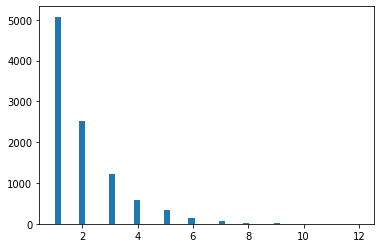

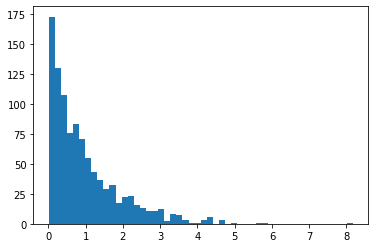

In [90]:
from scipy.stats import geom, expon
geom_distrib = geom(0.5).rvs(10000, random_state=42)
expon_distrib = expon(scale=1).rvs(1000, random_state=42)
plt.hist(geom_distrib, bins=50)
plt.show()
plt.hist(expon_distrib, bins=50)
plt.show()

# Excercises

## 1.

In [91]:
# Support Vector Machine Regressor (SVR)
from sklearn.model_selection import GridSearchCV

param_grid = [
    {"kernel": ["linear"], "C": [10.,30.,100.,300.,1000.,3000.,10000.,30000]},
    {"kernel": ["rbf"], "C": [1.0,3.0,10.0,30.0,100.0,300.0,1000.0],
    "gamma": [0.01,0.03,0.1,0.3,1.0,3.0]},
]

svm_reg = SVR()
grid_search = GridSearchCV(svm_reg, param_grid, cv=5,
                          scoring="neg_mean_squared_error",
                          verbose=2)

X = housing_prepared
y = housing_labels
grid_search.fit(X,y)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] C=10.0, kernel=linear ...........................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ............................ C=10.0, kernel=linear, total=   4.9s
[CV] C=10.0, kernel=linear ...........................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.8s remaining:    0.0s


[CV] ............................ C=10.0, kernel=linear, total=   4.9s
[CV] C=10.0, kernel=linear ...........................................
[CV] ............................ C=10.0, kernel=linear, total=   4.8s
[CV] C=10.0, kernel=linear ...........................................
[CV] ............................ C=10.0, kernel=linear, total=   4.8s
[CV] C=10.0, kernel=linear ...........................................
[CV] ............................ C=10.0, kernel=linear, total=   4.8s
[CV] C=30.0, kernel=linear ...........................................
[CV] ............................ C=30.0, kernel=linear, total=   4.8s
[CV] C=30.0, kernel=linear ...........................................
[CV] ............................ C=30.0, kernel=linear, total=   4.8s
[CV] C=30.0, kernel=linear ...........................................
[CV] ............................ C=30.0, kernel=linear, total=   4.9s
[CV] C=30.0, kernel=linear ...........................................
[CV] .

[CV] ..................... C=1.0, gamma=0.3, kernel=rbf, total=   7.4s
[CV] C=1.0, gamma=1.0, kernel=rbf ....................................
[CV] ..................... C=1.0, gamma=1.0, kernel=rbf, total=   7.4s
[CV] C=1.0, gamma=1.0, kernel=rbf ....................................
[CV] ..................... C=1.0, gamma=1.0, kernel=rbf, total=   7.2s
[CV] C=1.0, gamma=1.0, kernel=rbf ....................................
[CV] ..................... C=1.0, gamma=1.0, kernel=rbf, total=   7.3s
[CV] C=1.0, gamma=1.0, kernel=rbf ....................................
[CV] ..................... C=1.0, gamma=1.0, kernel=rbf, total=   7.2s
[CV] C=1.0, gamma=1.0, kernel=rbf ....................................
[CV] ..................... C=1.0, gamma=1.0, kernel=rbf, total=   7.3s
[CV] C=1.0, gamma=3.0, kernel=rbf ....................................
[CV] ..................... C=1.0, gamma=3.0, kernel=rbf, total=   8.0s
[CV] C=1.0, gamma=3.0, kernel=rbf ....................................
[CV] .

[CV] .................... C=10.0, gamma=0.3, kernel=rbf, total=   7.4s
[CV] C=10.0, gamma=0.3, kernel=rbf ...................................
[CV] .................... C=10.0, gamma=0.3, kernel=rbf, total=   7.5s
[CV] C=10.0, gamma=0.3, kernel=rbf ...................................
[CV] .................... C=10.0, gamma=0.3, kernel=rbf, total=   7.7s
[CV] C=10.0, gamma=1.0, kernel=rbf ...................................
[CV] .................... C=10.0, gamma=1.0, kernel=rbf, total=   7.7s
[CV] C=10.0, gamma=1.0, kernel=rbf ...................................
[CV] .................... C=10.0, gamma=1.0, kernel=rbf, total=   7.2s
[CV] C=10.0, gamma=1.0, kernel=rbf ...................................
[CV] .................... C=10.0, gamma=1.0, kernel=rbf, total=   7.5s
[CV] C=10.0, gamma=1.0, kernel=rbf ...................................
[CV] .................... C=10.0, gamma=1.0, kernel=rbf, total=   7.4s
[CV] C=10.0, gamma=1.0, kernel=rbf ...................................
[CV] .

[CV] ................... C=100.0, gamma=0.3, kernel=rbf, total=   7.7s
[CV] C=100.0, gamma=0.3, kernel=rbf ..................................
[CV] ................... C=100.0, gamma=0.3, kernel=rbf, total=   7.8s
[CV] C=100.0, gamma=0.3, kernel=rbf ..................................
[CV] ................... C=100.0, gamma=0.3, kernel=rbf, total=   7.8s
[CV] C=100.0, gamma=0.3, kernel=rbf ..................................
[CV] ................... C=100.0, gamma=0.3, kernel=rbf, total=   7.7s
[CV] C=100.0, gamma=0.3, kernel=rbf ..................................
[CV] ................... C=100.0, gamma=0.3, kernel=rbf, total=   7.8s
[CV] C=100.0, gamma=1.0, kernel=rbf ..................................
[CV] ................... C=100.0, gamma=1.0, kernel=rbf, total=   7.7s
[CV] C=100.0, gamma=1.0, kernel=rbf ..................................
[CV] ................... C=100.0, gamma=1.0, kernel=rbf, total=   8.2s
[CV] C=100.0, gamma=1.0, kernel=rbf ..................................
[CV] .

[CV] .................. C=1000.0, gamma=0.1, kernel=rbf, total=   7.6s
[CV] C=1000.0, gamma=0.1, kernel=rbf .................................
[CV] .................. C=1000.0, gamma=0.1, kernel=rbf, total=   7.7s
[CV] C=1000.0, gamma=0.3, kernel=rbf .................................
[CV] .................. C=1000.0, gamma=0.3, kernel=rbf, total=   7.7s
[CV] C=1000.0, gamma=0.3, kernel=rbf .................................
[CV] .................. C=1000.0, gamma=0.3, kernel=rbf, total=   7.7s
[CV] C=1000.0, gamma=0.3, kernel=rbf .................................
[CV] .................. C=1000.0, gamma=0.3, kernel=rbf, total=   7.5s
[CV] C=1000.0, gamma=0.3, kernel=rbf .................................
[CV] .................. C=1000.0, gamma=0.3, kernel=rbf, total=   7.5s
[CV] C=1000.0, gamma=0.3, kernel=rbf .................................
[CV] .................. C=1000.0, gamma=0.3, kernel=rbf, total=   7.6s
[CV] C=1000.0, gamma=1.0, kernel=rbf .................................
[CV] .

[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed: 31.7min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='scale', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'C': [10.0, 30.0, 100.0, 300.0, 1000.0, 3000.0,
                                10000.0, 30000],
                          'kernel': ['linear']},
                         {'C': [1.0, 3.0, 10.0, 30.0, 100.0, 300.0, 1000.0],
                          'gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0],
                          'kernel': ['rbf']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=2)

In [92]:
negative_mse = grid_search.best_score_
rmse = np.sqrt(-negative_mse)
rmse

70363.84006944533

In [93]:
grid_search.best_params_

{'C': 30000, 'kernel': 'linear'}

## 2.

In [94]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import expon, reciprocal

param_distribs = {
    "kernel": ["linear", "rbf"],
    "C": reciprocal(20, 200000),
    "gamma": expon(scale=1.0)
}

svm_reg = SVR()
rnd_search = RandomizedSearchCV(svm_reg, param_distributions=param_distribs,
                               n_iter=50, cv=5, scoring="neg_mean_squared_error",
                               verbose=2, random_state=42)
X = housing_prepared
y = housing_labels
rnd_search.fit(X,y)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] C=629.782329591372, gamma=3.010121430917521, kernel=linear ......


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=629.782329591372, gamma=3.010121430917521, kernel=linear, total=   5.0s
[CV] C=629.782329591372, gamma=3.010121430917521, kernel=linear ......


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.9s remaining:    0.0s


[CV]  C=629.782329591372, gamma=3.010121430917521, kernel=linear, total=   4.9s
[CV] C=629.782329591372, gamma=3.010121430917521, kernel=linear ......
[CV]  C=629.782329591372, gamma=3.010121430917521, kernel=linear, total=   5.1s
[CV] C=629.782329591372, gamma=3.010121430917521, kernel=linear ......
[CV]  C=629.782329591372, gamma=3.010121430917521, kernel=linear, total=   4.9s
[CV] C=629.782329591372, gamma=3.010121430917521, kernel=linear ......
[CV]  C=629.782329591372, gamma=3.010121430917521, kernel=linear, total=   5.0s
[CV] C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf ......
[CV]  C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf, total=   9.7s
[CV] C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf ......
[CV]  C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf, total=  10.0s
[CV] C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf ......
[CV]  C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf, total=   9.8s
[CV] C=26290.2

[CV]  C=171377.39570378003, gamma=0.628789100540856, kernel=linear, total=  44.0s
[CV] C=171377.39570378003, gamma=0.628789100540856, kernel=linear ....
[CV]  C=171377.39570378003, gamma=0.628789100540856, kernel=linear, total=  32.3s
[CV] C=171377.39570378003, gamma=0.628789100540856, kernel=linear ....
[CV]  C=171377.39570378003, gamma=0.628789100540856, kernel=linear, total=  41.4s
[CV] C=171377.39570378003, gamma=0.628789100540856, kernel=linear ....
[CV]  C=171377.39570378003, gamma=0.628789100540856, kernel=linear, total=  35.5s
[CV] C=171377.39570378003, gamma=0.628789100540856, kernel=linear ....
[CV]  C=171377.39570378003, gamma=0.628789100540856, kernel=linear, total=  28.0s
[CV] C=5385.293820172355, gamma=0.18696125197741642, kernel=linear ...
[CV]  C=5385.293820172355, gamma=0.18696125197741642, kernel=linear, total=   5.5s
[CV] C=5385.293820172355, gamma=0.18696125197741642, kernel=linear ...
[CV]  C=5385.293820172355, gamma=0.18696125197741642, kernel=linear, total=   5.6

[CV]  C=761.4316758498783, gamma=2.6126336514161914, kernel=linear, total=   4.6s
[CV] C=97392.81883041795, gamma=0.09265545895311562, kernel=linear ...
[CV]  C=97392.81883041795, gamma=0.09265545895311562, kernel=linear, total=  23.0s
[CV] C=97392.81883041795, gamma=0.09265545895311562, kernel=linear ...
[CV]  C=97392.81883041795, gamma=0.09265545895311562, kernel=linear, total=  22.6s
[CV] C=97392.81883041795, gamma=0.09265545895311562, kernel=linear ...
[CV]  C=97392.81883041795, gamma=0.09265545895311562, kernel=linear, total=  37.6s
[CV] C=97392.81883041795, gamma=0.09265545895311562, kernel=linear ...
[CV]  C=97392.81883041795, gamma=0.09265545895311562, kernel=linear, total=  24.0s
[CV] C=97392.81883041795, gamma=0.09265545895311562, kernel=linear ...
[CV]  C=97392.81883041795, gamma=0.09265545895311562, kernel=linear, total=  19.6s
[CV] C=2423.0759984939164, gamma=3.248614270240346, kernel=linear ....
[CV]  C=2423.0759984939164, gamma=3.248614270240346, kernel=linear, total=   

[CV]  C=56681.80859029545, gamma=0.9763011917123741, kernel=rbf, total=  25.1s
[CV] C=56681.80859029545, gamma=0.9763011917123741, kernel=rbf .......
[CV]  C=56681.80859029545, gamma=0.9763011917123741, kernel=rbf, total=  23.9s
[CV] C=48.15822390928914, gamma=0.4633351167983427, kernel=rbf .......
[CV]  C=48.15822390928914, gamma=0.4633351167983427, kernel=rbf, total=  11.0s
[CV] C=48.15822390928914, gamma=0.4633351167983427, kernel=rbf .......
[CV]  C=48.15822390928914, gamma=0.4633351167983427, kernel=rbf, total=  11.7s
[CV] C=48.15822390928914, gamma=0.4633351167983427, kernel=rbf .......
[CV]  C=48.15822390928914, gamma=0.4633351167983427, kernel=rbf, total=  11.7s
[CV] C=48.15822390928914, gamma=0.4633351167983427, kernel=rbf .......
[CV]  C=48.15822390928914, gamma=0.4633351167983427, kernel=rbf, total=  11.0s
[CV] C=48.15822390928914, gamma=0.4633351167983427, kernel=rbf .......
[CV]  C=48.15822390928914, gamma=0.4633351167983427, kernel=rbf, total=  11.1s
[CV] C=399.7268155705

[CV]  C=129.8000604143307, gamma=2.8621383676481322, kernel=linear, total=   7.7s
[CV] C=129.8000604143307, gamma=2.8621383676481322, kernel=linear ....
[CV]  C=129.8000604143307, gamma=2.8621383676481322, kernel=linear, total=   7.4s
[CV] C=129.8000604143307, gamma=2.8621383676481322, kernel=linear ....
[CV]  C=129.8000604143307, gamma=2.8621383676481322, kernel=linear, total=   7.7s
[CV] C=288.4269299593897, gamma=0.17580835850006285, kernel=rbf ......
[CV]  C=288.4269299593897, gamma=0.17580835850006285, kernel=rbf, total=  11.1s
[CV] C=288.4269299593897, gamma=0.17580835850006285, kernel=rbf ......
[CV]  C=288.4269299593897, gamma=0.17580835850006285, kernel=rbf, total=  11.6s
[CV] C=288.4269299593897, gamma=0.17580835850006285, kernel=rbf ......
[CV]  C=288.4269299593897, gamma=0.17580835850006285, kernel=rbf, total=  11.4s
[CV] C=288.4269299593897, gamma=0.17580835850006285, kernel=rbf ......
[CV]  C=288.4269299593897, gamma=0.17580835850006285, kernel=rbf, total=  11.3s
[CV] C=2

[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed: 56.3min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                                 epsilon=0.1, gamma='scale', kernel='rbf',
                                 max_iter=-1, shrinking=True, tol=0.001,
                                 verbose=False),
                   iid='deprecated', n_iter=50, n_jobs=None,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000022CC658E3C8>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000022CC658AE08>,
                                        'kernel': ['linear', 'rbf']},
                   pre_dispatch='2*n_jobs', random_state=42, refit=True,
                   return_train_score=False, scoring='neg_mean_squared_error',
                   verbose=2)

In [95]:
negative_mse = rnd_search.best_score_
rmse = np.sqrt(-negative_mse)
rmse

54767.960710084146

In [96]:
rnd_search.best_params_

{'C': 157055.10989448498, 'gamma': 0.26497040005002437, 'kernel': 'rbf'}

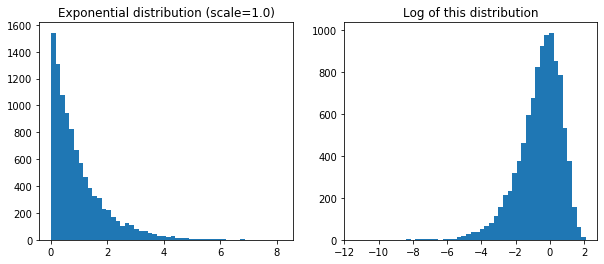

In [97]:
expon_distrib = expon(scale=1.)
samples = expon_distrib.rvs(10000, random_state=42)
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.title("Exponential distribution (scale=1.0)")
plt.hist(samples, bins=50)
plt.subplot(122)
plt.title("Log of this distribution")
plt.hist(np.log(samples), bins=50)
plt.show()

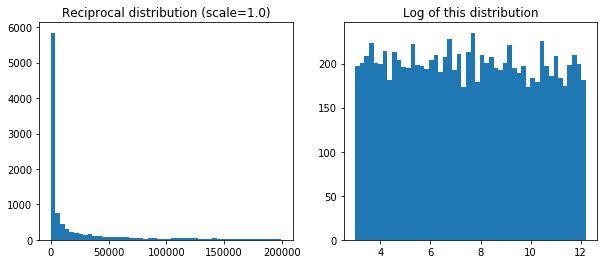

In [98]:
# useful when we dont know the scale of the hyperparameter
reciprocal_distrib = reciprocal(20, 200000)
samples = reciprocal_distrib.rvs(10000, random_state=42)
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.title("Reciprocal distribution (scale=1.0)")
plt.hist(samples, bins=50)
plt.subplot(122)
plt.title("Log of this distribution")
plt.hist(np.log(samples), bins=50)
plt.show()

# 3.

In [109]:
# adding a transformer in the prepration pipeline
# to select the most important attributes
from sklearn.base import BaseEstimator, TransformerMixin

def indices_of_top_k(arr, k):
    return np.sort(np.argpartition(np.array(arr), -k)[-k:])

class TopFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_importances, k):
        self.feature_importances = feature_importances
        self.k = k
    def fit(self, X, y=None):
        self.feature_indices_ = indices_of_top_k(self.feature_importances, self.k)
        return self
    def transform(self, X):
        return X[:, self.feature_indices_]
    
# assumes feature importance has been calculate i.e. RandomForestRegressor.
# computing them directly to TopFeaturesSelector's fit() will likely
# slow down grid/randomized search since the feature importances would
# have to be computed for every hyperparameter combination (unless you
# implement some sort of cache)

In [110]:
# __EXAMPLE__
# define a number of top features we want to keep
k = 5
top_k_feature_indices = indices_of_top_k(feature_importances, k)
top_k_feature_indices

array([ 0,  1,  7,  9, 12], dtype=int64)

In [111]:
np.array(attributes)[top_k_feature_indices]

array(['longitude', 'latitude', 'median_income', 'pop_per_hhold',
       'INLAND'], dtype='<U18')

In [112]:
sorted(zip(feature_importances, attributes), reverse=True)[:k]

[(0.36615898061813423, 'median_income'),
 (0.16478099356159054, 'INLAND'),
 (0.10879295677551575, 'pop_per_hhold'),
 (0.07334423551601243, 'longitude'),
 (0.06290907048262032, 'latitude')]

In [113]:
# create new pipeline that runs previously defined preparation pipeline
# and adds top k feature selection
preparation_and_feature_selection_pipeline = Pipeline([
    ("preparation", full_pipeline),
    ("feature_selection", TopFeatureSelector(feature_importances, k))
])

In [114]:
housing_prepared_top_k_features = preparation_and_feature_selection_pipeline.fit_transform(housing)

In [115]:
# looking at the features for the first 3 instances
housing_prepared_top_k_features[0:3]

array([[-1.15604281,  0.77194962, -0.61493744, -0.08649871,  0.        ],
       [-1.17602483,  0.6596948 ,  1.33645936, -0.03353391,  0.        ],
       [ 1.18684903, -1.34218285, -0.5320456 , -0.09240499,  0.        ]])

In [116]:
housing_prepared[0:3, top_k_feature_indices]

array([[-1.15604281,  0.77194962, -0.61493744, -0.08649871,  0.        ],
       [-1.17602483,  0.6596948 ,  1.33645936, -0.03353391,  0.        ],
       [ 1.18684903, -1.34218285, -0.5320456 , -0.09240499,  0.        ]])

# 4.

In [117]:
# creating a single pipeline for data prep and final prediction
prepare_select_and_predict_pipeline = Pipeline([
    ("preparation", full_pipeline),
    ("feature_selection", TopFeatureSelector(feature_importances, k)),
    ("svm_reg", SVR(**rnd_search.best_params_))
])

In [118]:
X = housing
y - housing_labels
prepare_select_and_predict_pipeline.fit(X, y)

Pipeline(memory=None,
         steps=[('preparation',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='median',
                                                              

In [119]:
some_data = housing.iloc[:4]
some_labels = housing_labels.iloc[:4]

print("Predictions:\t", prepare_select_and_predict_pipeline.predict(some_data))
print("Labels:\t\t", list(some_labels))

Predictions:	 [203214.28978849 371846.88152572 173295.65441612  47328.3970888 ]
Labels:		 [286600.0, 340600.0, 196900.0, 46300.0]


# 5.

In [129]:
# auto explore some preparation options using GridSearchCV
# param_grid = [{
#     "preparation__num__imputer__strategy": ["mean", "median", "most_frequent"],
#     "feature__selection__k": list(range(1, len(feature_importances) + 1))
# }]

param_grid = [{
    'preparation__num__imputer__strategy': ['mean', 'median', 'most_frequent'],
    'feature_selection__k': list(range(1, len(feature_importances) + 1))
}]

grid_search_prep = GridSearchCV(prepare_select_and_predict_pipeline, param_grid, cv=5,
                               scoring="neg_mean_squared_error", verbose=2)
X = housing
y - housing_labels
grid_search_prep.fit(X,y)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] feature_selection__k=1, preparation__num__imputer__strategy=mean 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  feature_selection__k=1, preparation__num__imputer__strategy=mean, total=   5.1s
[CV] feature_selection__k=1, preparation__num__imputer__strategy=mean 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.0s remaining:    0.0s


[CV]  feature_selection__k=1, preparation__num__imputer__strategy=mean, total=   5.2s
[CV] feature_selection__k=1, preparation__num__imputer__strategy=mean 
[CV]  feature_selection__k=1, preparation__num__imputer__strategy=mean, total=   5.2s
[CV] feature_selection__k=1, preparation__num__imputer__strategy=mean 
[CV]  feature_selection__k=1, preparation__num__imputer__strategy=mean, total=   5.6s
[CV] feature_selection__k=1, preparation__num__imputer__strategy=mean 
[CV]  feature_selection__k=1, preparation__num__imputer__strategy=mean, total=   6.0s
[CV] feature_selection__k=1, preparation__num__imputer__strategy=median 
[CV]  feature_selection__k=1, preparation__num__imputer__strategy=median, total=   5.5s
[CV] feature_selection__k=1, preparation__num__imputer__strategy=median 
[CV]  feature_selection__k=1, preparation__num__imputer__strategy=median, total=   5.4s
[CV] feature_selection__k=1, preparation__num__imputer__strategy=median 
[CV]  feature_selection__k=1, preparation__num__

[CV]  feature_selection__k=4, preparation__num__imputer__strategy=median, total=   7.2s
[CV] feature_selection__k=4, preparation__num__imputer__strategy=median 
[CV]  feature_selection__k=4, preparation__num__imputer__strategy=median, total=   7.3s
[CV] feature_selection__k=4, preparation__num__imputer__strategy=median 
[CV]  feature_selection__k=4, preparation__num__imputer__strategy=median, total=   7.9s
[CV] feature_selection__k=4, preparation__num__imputer__strategy=most_frequent 
[CV]  feature_selection__k=4, preparation__num__imputer__strategy=most_frequent, total=   6.9s
[CV] feature_selection__k=4, preparation__num__imputer__strategy=most_frequent 
[CV]  feature_selection__k=4, preparation__num__imputer__strategy=most_frequent, total=   9.2s
[CV] feature_selection__k=4, preparation__num__imputer__strategy=most_frequent 
[CV]  feature_selection__k=4, preparation__num__imputer__strategy=most_frequent, total=   9.6s
[CV] feature_selection__k=4, preparation__num__imputer__strategy=

[CV]  feature_selection__k=7, preparation__num__imputer__strategy=most_frequent, total=  11.6s
[CV] feature_selection__k=7, preparation__num__imputer__strategy=most_frequent 
[CV]  feature_selection__k=7, preparation__num__imputer__strategy=most_frequent, total=  10.0s
[CV] feature_selection__k=7, preparation__num__imputer__strategy=most_frequent 
[CV]  feature_selection__k=7, preparation__num__imputer__strategy=most_frequent, total=  11.7s
[CV] feature_selection__k=8, preparation__num__imputer__strategy=mean 
[CV]  feature_selection__k=8, preparation__num__imputer__strategy=mean, total=  15.1s
[CV] feature_selection__k=8, preparation__num__imputer__strategy=mean 
[CV]  feature_selection__k=8, preparation__num__imputer__strategy=mean, total=  13.2s
[CV] feature_selection__k=8, preparation__num__imputer__strategy=mean 
[CV]  feature_selection__k=8, preparation__num__imputer__strategy=mean, total=  14.9s
[CV] feature_selection__k=8, preparation__num__imputer__strategy=mean 
[CV]  feature

[CV]  feature_selection__k=11, preparation__num__imputer__strategy=mean, total=  16.0s
[CV] feature_selection__k=11, preparation__num__imputer__strategy=mean 
[CV]  feature_selection__k=11, preparation__num__imputer__strategy=mean, total=  17.1s
[CV] feature_selection__k=11, preparation__num__imputer__strategy=mean 
[CV]  feature_selection__k=11, preparation__num__imputer__strategy=mean, total=  16.4s
[CV] feature_selection__k=11, preparation__num__imputer__strategy=median 
[CV]  feature_selection__k=11, preparation__num__imputer__strategy=median, total=  14.5s
[CV] feature_selection__k=11, preparation__num__imputer__strategy=median 
[CV]  feature_selection__k=11, preparation__num__imputer__strategy=median, total=  14.3s
[CV] feature_selection__k=11, preparation__num__imputer__strategy=median 
[CV]  feature_selection__k=11, preparation__num__imputer__strategy=median, total=  14.6s
[CV] feature_selection__k=11, preparation__num__imputer__strategy=median 
[CV]  feature_selection__k=11, p

[CV]  feature_selection__k=14, preparation__num__imputer__strategy=median, total=  54.9s
[CV] feature_selection__k=14, preparation__num__imputer__strategy=median 
[CV]  feature_selection__k=14, preparation__num__imputer__strategy=median, total=  54.2s
[CV] feature_selection__k=14, preparation__num__imputer__strategy=median 
[CV]  feature_selection__k=14, preparation__num__imputer__strategy=median, total=  50.2s
[CV] feature_selection__k=14, preparation__num__imputer__strategy=most_frequent 
[CV]  feature_selection__k=14, preparation__num__imputer__strategy=most_frequent, total=  54.5s
[CV] feature_selection__k=14, preparation__num__imputer__strategy=most_frequent 
[CV]  feature_selection__k=14, preparation__num__imputer__strategy=most_frequent, total=  47.6s
[CV] feature_selection__k=14, preparation__num__imputer__strategy=most_frequent 
[CV]  feature_selection__k=14, preparation__num__imputer__strategy=most_frequent, total=  49.8s
[CV] feature_selection__k=14, preparation__num__impute

[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed: 81.2min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preparation',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('num',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('imputer',
                                                                                          SimpleImputer(add_indicator=False,
                                                                                                        copy=True,
                                     

In [ ]:
grid_search_prep.best_params_